<a href="https://colab.research.google.com/github/plaban1981/NLP/blob/master/Toxic_Comment_Classification_Challenge_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Problem Statement
For simplicity, we will only focus on the basic toxic class. Given a text comment, can our classifier determine whether this comment is toxic?

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [25]:
!pip install patool

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 77 kB 4.4 MB/s 


In [26]:
import patoolib
patoolib.extract_archive("/content/drive/MyDrive/NLP_RAM/Toxicity_classifaction/glove.6B.100d.txt.zip",outdir="/content/drive/MyDrive/NLP_RAM/Toxicity_classifaction")

patool: Extracting /content/drive/MyDrive/NLP_RAM/Toxicity_classifaction/glove.6B.100d.txt.zip ...
patool: running /usr/bin/7z x -o/content/drive/MyDrive/NLP_RAM/Toxicity_classifaction -- /content/drive/MyDrive/NLP_RAM/Toxicity_classifaction/glove.6B.100d.txt.zip
patool: ... /content/drive/MyDrive/NLP_RAM/Toxicity_classifaction/glove.6B.100d.txt.zip extracted to `/content/drive/MyDrive/NLP_RAM/Toxicity_classifaction'.


'/content/drive/MyDrive/NLP_RAM/Toxicity_classifaction'

In [6]:
patoolib.extract_archive("/content/drive/MyDrive/NLP_RAM/Toxicity_classifaction/test.csv.zip",outdir="/content/drive/MyDrive/NLP_RAM/Toxicity_classifaction")

patool: Extracting /content/drive/MyDrive/NLP_RAM/Toxicity_classifaction/test.csv.zip ...
patool: running /usr/bin/7z x -o/content/drive/MyDrive/NLP_RAM/Toxicity_classifaction -- /content/drive/MyDrive/NLP_RAM/Toxicity_classifaction/test.csv.zip
patool: ... /content/drive/MyDrive/NLP_RAM/Toxicity_classifaction/test.csv.zip extracted to `/content/drive/MyDrive/NLP_RAM/Toxicity_classifaction'.


'/content/drive/MyDrive/NLP_RAM/Toxicity_classifaction'

In [2]:
train_data_path = "/content/drive/MyDrive/NLP_RAM/Toxicity_classifaction/train.csv"
test_data_path = "/content/drive/MyDrive/NLP_RAM/Toxicity_classifaction/test.csv"

In [4]:
import pandas as pd


In [5]:
df_train = pd.read_csv(train_data_path)
df_test = pd.read_csv(test_data_path)

In [6]:
df_train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [7]:
df_test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


## Check for null values

In [8]:
df_train.isnull().sum()[df_train.isnull().sum() > 0]

Series([], dtype: int64)

In [9]:
df_test.isnull().sum()[df_test.isnull().sum() > 0]

Series([], dtype: int64)

In [10]:
toxic_comments = df_train.copy()

In [11]:
toxic_comments.shape

(159571, 8)

In [12]:
filter = toxic_comments["comment_text"] != ""
toxic_comments = toxic_comments[filter]
toxic_comments = toxic_comments.dropna()

In [13]:
print(toxic_comments["comment_text"][168])

You should be fired, you're a moronic wimp who is too lazy to do research. It makes me sick that people like you exist in this world.


In [14]:
toxic_comments_labels = toxic_comments[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]]
toxic_comments_labels.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0


In [15]:
def preprocess_text(sen):
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [16]:
toxic_comments.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [17]:
df_train.shape

(159571, 8)

## Preprocess text

In [19]:
from numpy import array
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense
from tensorflow.keras.layers import Flatten, LSTM
from tensorflow.keras.layers import GlobalMaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Concatenate

import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt

In [20]:
X = []
sentences = list(toxic_comments["comment_text"])
for sen in sentences:
    X.append(preprocess_text(sen))

y = toxic_comments_labels.values

In [35]:
y

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [22]:

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
#

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 200

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [43]:
import joblib
joblib.dump(tokenizer,"/content/drive/MyDrive/NLP_RAM/Toxicity_classifaction/tokenizer.pkl")

['/content/drive/MyDrive/NLP_RAM/Toxicity_classifaction/tokenizer.pkl']

In [27]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()

glove_file = open('/content/drive/MyDrive/NLP_RAM/Toxicity_classifaction/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [28]:
deep_inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(deep_inputs)
LSTM_Layer_1 = LSTM(128)(embedding_layer)
dense_layer_1 = Dense(6, activation='sigmoid')(LSTM_Layer_1)
model = Model(inputs=deep_inputs, outputs=dense_layer_1)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [29]:
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding (Embedding)       (None, 200, 100)          14824300  
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 6)                 774       
                                                                 
Total params: 14,942,322
Trainable params: 118,022
Non-trainable params: 14,824,300
_________________________________________________________________
None


In [36]:
model.save('/content/drive/MyDrive/NLP_RAM/Toxicity_classifaction/text_classification.h5')

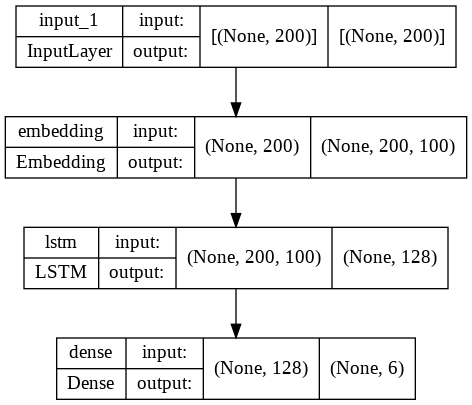

In [31]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)

In [32]:
history = model.fit(X_train, y_train, batch_size=128, epochs=5, verbose=1, validation_split=0.2)

Epoch 1/5
798/798 [==============================] - 21s 19ms/step - loss: 0.1411 - acc: 0.9787 - val_loss: 0.0934 - val_acc: 0.9942
Epoch 2/5
798/798 [==============================] - 15s 18ms/step - loss: 0.1040 - acc: 0.9768 - val_loss: 0.0681 - val_acc: 0.9905
Epoch 3/5
798/798 [==============================] - 14s 18ms/step - loss: 0.0636 - acc: 0.9923 - val_loss: 0.0610 - val_acc: 0.9940
Epoch 4/5
798/798 [==============================] - 15s 18ms/step - loss: 0.0590 - acc: 0.9932 - val_loss: 0.0583 - val_acc: 0.9927
Epoch 5/5
798/798 [==============================] - 15s 18ms/step - loss: 0.0564 - acc: 0.9935 - val_loss: 0.0566 - val_acc: 0.9943


In [33]:
score = model.evaluate(X_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

998/998 [==============================] - 6s 6ms/step - loss: 0.0551 - acc: 0.9940
Test Score: 0.05507459118962288
Test Accuracy: 0.994046688079834


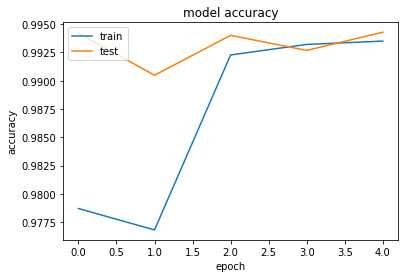

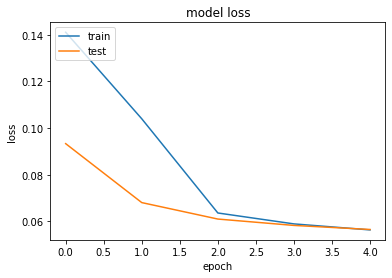

In [34]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

## Inference script

In [37]:
from tensorflow.keras.models import load_model
model=load_model("/content/drive/MyDrive/NLP_RAM/Toxicity_classifaction/text_classification.h5")

In [38]:
df_test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [41]:
test_data = []
sentences = list(df_test["comment_text"])
for sen in sentences:
    test_data.append(preprocess_text(sen))

In [44]:
tokenizer = joblib.load("/content/drive/MyDrive/NLP_RAM/Toxicity_classifaction/tokenizer.pkl")

In [45]:
test_inp = tokenizer.texts_to_sequences(test_data)

In [47]:
vocab_size = len(tokenizer.word_index) + 1
maxlen = 200
test_inp = pad_sequences(test_inp, padding='post', maxlen=maxlen)

In [48]:
test_inp

array([[2449,  742,  614, ...,    0,    0,    0],
       [  29, 1105,    1, ...,    0,    0,    0],
       [ 110,   13,    0, ...,    0,    0,    0],
       ...,
       [1126,   62,   18, ...,    0,    0,    0],
       [  44,    3,    1, ...,    0,    0,    0],
       [ 171,  228,   18, ...,    0,    0,    0]], dtype=int32)

In [50]:
predictions = model.predict(test_inp)

In [54]:
predictions.shape

(153164, 6)

In [61]:
arr = np.array(predictions[0])
print(arr)
labels = [0,0,0,0,0,0]
labels[np.argmax(arr,axis=0)] =1
labels

[0.9892915  0.38746285 0.96607745 0.0442348  0.86283517 0.17076771]


[1, 0, 0, 0, 0, 0]

In [77]:
lbl = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

In [70]:
labels = []
for indx in np.argmax(predictions,axis=1):
  label = [0,0,0,0,0,0]
  label[indx] = 1
  labels.append(label)

In [86]:
pd.DataFrame(np.array(labels),columns=lbl).to_json("a.json",index=True)

In [81]:
from datetime import datetime
print(datetime.now())

2022-08-11 13:11:24.382935


In [85]:
from numpy import array
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense
from tensorflow.keras.layers import Flatten, LSTM
from tensorflow.keras.layers import GlobalMaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.models import load_model

from datetime import datetime
import pandas as pd
import numpy as np
import re
import json
import joblib


def preprocess_function(input_data):
    tokenizer = joblib.load("/content/drive/MyDrive/NLP_RAM/Toxicity_classifaction/tokenizer.pkl")
    test_data = []
    sentences = list(input_data["comment_text"])
    for sen in sentences:
      # Remove punctuations and numbers
      sen = re.sub('[^a-zA-Z]', ' ', sen)
      # Single character removal
      sen = re.sub(r"\s+[a-zA-Z]\s+", ' ', sen)
      # Removing multiple spaces
      sen = re.sub(r'\s+', ' ', sen)
      test_data.append(preprocess_text(sen))
    test_inp = tokenizer.texts_to_sequences(test_data)
    vocab_size = len(tokenizer.word_index) + 1
    maxlen = 200
    test_inp = pad_sequences(test_inp, padding='post', maxlen=maxlen)

    return test_inp

#
def predict_function(input_data, model):
    
    # Predict image using model
    predictions = model.predict(input_data)
    # Get top predicted class label
    return predictions
#
def model_load_function(model_file):
    # load model
    model=load_model(model_file)
    return model
#
def postprocess_function(predictions):
    labels = []
    for indx in np.argmax(predictions,axis=1):
      label = [0,0,0,0,0,0]
      label[indx] = 1
      labels.append(label)
    lbl = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
    output = pd.DataFrame(np.array(labels),columns=lbl)
    tmc = datetime.now()
    file_name = "comment_classification_" + str(tmc) +".json"
    output.to_json(file_name,index=True)
    return json.dumps({"response": "Predicted labels for text is placed at : {}".format(file_name)})

if __name__ == "__main__":
    model_file = "/content/drive/MyDrive/NLP_RAM/Toxicity_classifaction/text_classification.h5"
    data_path = "/content/drive/MyDrive/NLP_RAM/Toxicity_classifaction/test.csv"
    data = pd.read_csv(data_path)
    input_data = preprocess_function(data)
    model = model_load_function(model_file)
    prediction = predict_function(input_data, model)
    output = postprocess_function(prediction)
    print(np.array(output))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

